# 라이브러리

In [4]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
#from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import random
import pingouin as pg

#from ggplot import *
#from scipy.stats import logistic
#from sklearn.metrics import roc_curve
#from sklearn.metrics import roc_auc_score
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
#from sklearn import preprocessing
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import *
#from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
#import graphviz
#from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
#from sklearn.svm import SVC, SVR
from matplotlib.ticker import FuncFormatter
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm


# 한글 폰트 실행
from matplotlib import rcParams
from matplotlib import font_manager,rc
rcParams['axes.unicode_minus']=False
plt.rcParams['font.family']='NanumGothic'
font_name=font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font',family=font_name)


# 사용자정의함수

## 데이터 용량 조정 함수

In [2]:
import pandas as pd 
import numpy as np

def reduce_mem_usage(df, float16_as32=True):
    # memory_usage()는 데이터프레임의 각 열의 메모리 사용량을 계산하고, sum은 그 값을 합산합니다. B -> KB -> MB로 변환합니다.
    start_mem = df.memory_usage().sum() / 1024**2
    print('데이터프레임의 초기 메모리 사용량은 {:.2f} MB입니다.'.format(start_mem))

    for col in df.columns:  # 각 열의 이름을 반복합니다.
        col_type = df[col].dtype  # 열의 데이터 타입을 가져옵니다.
        if col_type != object and str(col_type) != 'category':  # 객체 타입이 아닌 수치형 변수만 처리합니다.
            c_min, c_max = df[col].min(), df[col].max()  # 해당 열의 최소값과 최대값을 계산합니다.
            if str(col_type)[:3] == 'int':  # 정수형 변수일 경우 (int8, int16, int32, int64 모두 포함)
                # 이 열의 값 범위가 int8의 범위에 있을 경우 타입을 int8로 변환합니다. (-128부터 127까지)
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                # 이 열의 값 범위가 int16의 범위에 있을 경우 타입을 int16으로 변환합니다. (-32,768부터 32,767까지)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                # 이 열의 값 범위가 int32의 범위에 있을 경우 타입을 int32로 변환합니다. (-2,147,483,648부터 2,147,483,647까지)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                # 이 열의 값 범위가 int64의 범위에 있을 경우 타입을 int64로 변환합니다. (-9,223,372,036,854,775,808부터 9,223,372,036,854,775,807까지)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:  # 실수형일 경우
                # 값이 float16의 범위에 있을 경우 타입을 변환합니다. 더 높은 정밀도가 필요하면 float32를 고려합니다.
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    if float16_as32:  # 더 높은 정밀도가 필요하면 float32를 선택할 수 있습니다.
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float16)
                # 값이 float32의 범위에 있을 경우 타입을 float32로 변환합니다.
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                # 값이 float64의 범위에 있을 경우 타입을 float64로 변환합니다.
                else:
                    df[col] = df[col].astype(np.float64)
    # 최종 메모리 사용량을 계산합니다.
    end_mem = df.memory_usage().sum() / 1024**2
    print('최적화 후 데이터프레임의 메모리 사용량은: {:.2f} MB입니다.'.format(end_mem))
    # 초기 메모리 사용량과 비교하여 몇 퍼센트 감소했는지 계산합니다.
    print('메모리 사용량이 {:.1f}% 감소했습니다.'.format(100 * (start_mem - end_mem) / start_mem))

    return df



import time

def execution_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"Execution time for {func.__name__}: {int(hours)}h {int(minutes)}m {seconds:.2f}s")
        return result
    return wrapper



@execution_time
def clean_df(data):
    data['고객ID'] = data['고객ID'].astype(str)
    data = reduce_mem_usage(data)
    return data


## 분석 도움 함수

In [3]:
# 재분류
def rename_category_store(df):
    """
    가맹점 업종명을 지정된 카테고리로 재분류하는 함수입니다.

    이 함수는 입력된 데이터프레임의 '가맹점업종명' 열에 대해 특정 값들을 지정된 카테고리 이름으로
    대체하여 재분류합니다. 이를 통해 다양한 업종명이 지정된 범주의 카테고리로 통합됩니다.

    Parameters:
    df (pd.DataFrame): '가맹점업종명' 열을 포함한 데이터프레임.

    Returns:
    pd.DataFrame: '가맹점업종명' 열이 재분류된 데이터프레임.

    Example:
    >>> data = pd.DataFrame({
    ...     '가맹점업종명': ['보습학원', '피부미용실', '골프경기장', '주점', '약 국'],
    ...     '승인금액': [10000, 20000, 30000, 40000, 50000]
    ... })
    >>> rename_category_store(data)
    가맹점업종명 열을 다음과 같은 카테고리로 재분류합니다: ['교육/학원', '미용', '스포츠/레저', '외식', '의료/보험']
    
    """
    mapping = {
        '교육/학원': ['보습학원', '예·체능계학원', '외국어학원', '기타 교육기관', '기능학원', '학원', '학습지교육', '초중고교육기관'],
        '미용': ['미용원', '피부미용실'],
        '스포츠/레저': ['기타레져업소', '스포츠·레져용품', '스포츠의류', '스크린골프', '헬스클럽', '골프경기장', '종합레져타운', '골프용품 전문점', '골프연습장', '안마/스포츠마사지', '레져업소', '수 영 장'],
        '여행/교통': ['기타숙박업', '철도', '특급호텔', '1급 호텔', '렌터카', '항공사', '콘도', '2급 호텔', '관광여행', '여객선', '고속버스', '택시'],
        '외식': ['일반한식', '주점', '서양음식', '중국식', '일식·회집', '한정식', '칵테일바', '갈비전문점'],
        '대형마트': ['슈퍼마켓', '농협하나로클럽', '농,축협직영매장', '대형할인점'],
        '백화점': ['면 세 점', '자사카드발행백화점'],
        '편의점': ['편 의 점'],
        '음식료품': ['정육점', '스넥', '농·축·수산품', '농축수산가공품', '주류판매점', '홍삼제품', '인삼제품', '기타건강식품'],
        '카페/베이커리': ['기타음료식품', '제과점'],
        '의료/보험': ['약 국', '의 원', '한 의 원', '치과의원', '기타의료기관 및 기타의료기기', '한약방', '한방병원', '생명보험', '건강진단', '기타보험', '병 원(응급실운영)', '치과병원', '동물병원', '종합병원', '손해보험'],
        '주유': ['SK주유소', '쌍용S-OIL', 'GS주유소', '주유소', 'SK가스충전소', '현대정유(오일뱅크)', 'GS가스충전소', '쌍용S-OIL가스충전소', '현대정유가스충전소', 'E1가스충전소', '전기차충전소'],
        '문화생활': ['문화취미기타', '영화관', '티켓'],
        '이동통신요금': ['이동통신요금'],
        '반려동물': ['애완동물'],
        '간편결제': ['인터넷P/G'],
        '기타': ['전자상거래상품권전문판매', '캐주얼의류', 'CATV', '택시회사', '위성방송', '음반영상물', '제 화','주방용구', '연 쇄 점', '액세서리', '전문서적', '주차장', '민예·공예품', '건축용 요업제품', '단란주점', '옷감·직물', '자동차시트·타이어', '독서실', '농기계', '조명기구', '세차장', '사무서비스', '컴퓨터', '가 방', '보일러·펌프·샷시', '카페트,커튼,천막,지물', '자동차부품', '자동차정비', '기타유통업', '이륜차판매', '카인테리어', '화물운송', '내의판매', '목재·석재·철물', '기타 사무용품', '기타가구', '신 발', '비영리/비대상', '기타대인서비스', '기타전기제품', 'DP&E', '주방용식기', '가타자동차서비스', '기타농업관련', '구내매점(국가기관등)', '아동의류', '이용원', '조세서비스', '기념품점', '유흥주점', '통신기기', '화원', '화장품', '기타잡화', '유아원', 'LPG취급점', '페인트', '출판 및 인쇄물', '귀금속', '문구용품', '위탁급식업', '비료,사료,종자', '침구·수예점', '당구장', '가전제품', '인터넷Mall', '가정용품수리', '사무·통신기기수리', '안경', '세탁소', '사우나', '일반서적', '노 래 방', '기계공구',  '완구점', '기타의류', '미곡상', '기타용역서비스', '기타수리서비스', '기타건축자재', '일반가구', '사무용 OA기기', '인테리어전문', '가례서비스업', '시 계', '비영리/대상', '윤활유전문판매', '정수기', '공공요금대행서비스/소득공제비대상', '화방·표구점', '볼 링 장', '인터넷종합Mall', '기타 전문점', '통신판매업1', '종합용역', '전자상거래상품권', '보관및 창고업', '유류판매', '업종미등록', '통신서비스/소득공제비대상', '기타서적문구', '수족관', '공공요금대행서비스/소득공제대상', '상품권전문판매', '혼례서비스업', '냉열기기', '비씨카드 정산용(할인)', '일반(통신판매)', '기타4', '기타1', '부동산중개·임대', 'CATV홈쇼핑', '소프트웨어', '의료용품', '정장', '맞춤복점', '단체복', '상 품 권', 'PG상품권', '비씨카드 정산용가맹점',  '미용재료']
    }
    for category, values in mapping.items():
        df['가맹점업종명'] = df['가맹점업종명'].replace(values, category)
    print(df['가맹점업종명'].unique())
    return df

def rename_category_store_5(df):
    """
    가맹점 업종명을 미리 정의된 카테고리로 분류하여 새로운 '분류' 컬럼에 추가하는 함수입니다.

    이 함수는 입력된 데이터프레임의 '가맹점업종명' 열의 값들을 사전 정의된 카테고리로 매핑하여,
    각 가맹점이 해당하는 카테고리 정보를 새로운 '분류' 컬럼에 추가합니다. 이를 통해 다양한 업종을
    지정된 범주의 카테고리로 분류하여 분석할 수 있습니다.

    Parameters:
    df (pd.DataFrame): '가맹점업종명' 열을 포함한 데이터프레임.

    Returns:
    pd.DataFrame: '분류' 열이 추가된 데이터프레임.

    Example:
    >>> data = pd.DataFrame({
    ...     '가맹점업종명': ['백화점', '피부미용실', '골프경기장', '주점', '약국'],
    ...     '승인금액': [10000, 20000, 30000, 40000, 50000]
    ... })
    >>> rename_category_store_5(data)
    가맹점업종명 열을 다음과 같은 카테고리로 재분류합니다: ['쇼핑', '기타', '여가', '기타', '식음료']
    
    Categories:
      - 생활비: ['이동통신요금', '의료/보험', '교육/학원', '반려동물', '주유', '미용']
      - 식음료: ['외식', '카페/베이커리', '음식료품']
      - 쇼핑: ['백화점', '홈쇼핑', '온라인쇼핑', '간편결제', '편의점', '대형마트']
      - 여가: ['스포츠/레저', '여행/교통', '문화생활']
      - 기타: ['기타']
    
    """
    
    mapping = {
       '생활비' : ['이동통신요금', '의료/보험' , '교육/학원', '반려동물', '주유', '미용'],
        '식음료' : ['외식', '카페/베이커리', '음식료품'],
        '쇼핑' : ['백화점', '홈쇼핑', '온라인쇼핑', '간편결제', '편의점', '대형마트'],
        '여가' : ['스포츠/레저', '여행/교통', '문화생활'],
        '기타' : ['기타']
    }
 
    df['분류'] = df['가맹점업종명']
    for category, values in mapping.items():
        df.loc[df['가맹점업종명'].isin(values), '분류'] = category

    print(df['분류'].unique())
    return df


def rename_category_region(df):
    """
    가맹점 위치의 광역시도를 지정된 지역권으로 재분류하는 함수입니다.

    이 함수는 데이터프레임의 '가맹점_광역시도' 열에 대해 지역별 분류를 수행하여,
    수도권, 영남권, 충청권, 호남권, 강원·제주권으로 대체합니다.

    Parameters:
    df (pd.DataFrame): '가맹점_광역시도' 열을 포함한 데이터프레임.

    Returns:
    pd.DataFrame: '가맹점_광역시도' 열이 지역권으로 재분류된 데이터프레임.

    Example:
    >>> data = pd.DataFrame({
    ...     '가맹점_광역시도': ['서울특별시', '부산광역시', '제주특별자치도', '경기도', '대전광역시'],
    ...     '승인금액': [10000, 20000, 15000, 5000, 3000]
    ... })
    >>> rename_category_region(data)
    '가맹점_광역시도' 열을 다음과 같이 재분류합니다: 수도권, 영남권, 강원·제주권, 충청권 등.
    """
    region_groups = {
        '서울특별시': '수도권', '경기도': '수도권', '인천광역시': '수도권',
        '부산광역시': '영남권', '울산광역시': '영남권', '경상남도': '영남권',
        '충청북도': '충청권', '충청남도': '충청권', '대전광역시': '충청권', '세종특별자치시': '충청권',
        '전북특별자치도': '호남권', '전라남도': '호남권', '광주광역시': '호남권',
        '강원특별자치도': '강원·제주권', '제주특별자치도': '강원·제주권'
    }

    df['가맹점_광역시도'] = df['가맹점_광역시도'].replace(region_groups)
    df['가맹점_광역시도'].value_counts()
    return df

def join(df1, df2, key, way):
    """
    두 데이터프레임을 지정된 키와 조인 방식에 따라 병합하는 함수입니다.

    이 함수는 `pd.merge`를 사용하여 두 데이터프레임을 특정 열(`key`)을 기준으로 
    주어진 조인 방식(`way`)에 따라 병합합니다. 병합 결과는 데이터프레임 형식으로 반환됩니다.

    Parameters:
    df1 (pd.DataFrame): 첫 번째 데이터프레임.
    df2 (pd.DataFrame): 두 번째 데이터프레임.
    key (str): 조인할 때 사용할 공통 열의 이름.
    way (str): 조인 방식 (예: 'inner', 'left', 'right', 'outer').

    Returns:
    pd.DataFrame: 지정된 키와 방식으로 병합된 데이터프레임.

    Example:
    >>> df1 = pd.DataFrame({'ID': [1, 2, 3], 'Value1': ['A', 'B', 'C']})
    >>> df2 = pd.DataFrame({'ID': [2, 3, 4], 'Value2': ['X', 'Y', 'Z']})
    >>> join(df1, df2, key='ID', way='inner')
    <class 'pandas.core.frame.DataFrame'>
       ID Value1 Value2
    0   2      B      X
    1   3      C      Y
    """
    df_joined = pd.merge(df1, df2, on=f'{key}', how=f'{way}')
    print(type(df_joined))
    print(df_joined.head(3))
    return df_joined


## 시각화 관련 함수 ( 다 필요한 건 아님 )

In [4]:
def countplot_test(df, feature):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(8, 6))
    ax = sns.countplot(data=df, x=feature, palette="viridis")
    ax.set_title(f" {feature}")
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,  
            p.get_height() + 0.5,           
            int(p.get_height()),            
            ha='center',      
            fontsize=8    
        )
plt.show()

In [5]:
def simple_boxplots(df, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(12, 6)) 
    if len(columns) == 1:
        axes = [axes]
    
    for i, col in enumerate(columns):
        sns.boxplot(y=df[col], palette='viridis', ax=axes[i])  
        axes[i].set_title(f'Box Plot of {col}')  
    plt.tight_layout() 
    plt.show()

In [6]:
def age_balance_boxplot(df, age_column, balance_column):
    fig, axes = plt.subplots(figsize=(8, 6))
    ax = sns.boxplot(data=df, x=age_column, y=balance_column, palette="Set2")
    ax.set_title(f"{age_column} 별 {balance_column}")
    ax.set_xlabel(f"{age_column}")
    ax.set_ylabel(f"{balance_column}")
    plt.show()

## 이상치 관련 함수

In [7]:
# 사분위수 활용해서 이상치 개수 구하기
def count_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_outliers = df[df[column] < (Q1 - 1.5 * IQR)]
    upper_outliers = df[df[column] > (Q3 + 1.5 * IQR)]
    outlier_count = lower_outliers.shape[0] + upper_outliers.shape[0]
    print(f"이상치 개수: {outlier_count}")
    return outlier_count

# 데이터불러오기

In [5]:
import pandas as pd
DATA_PATH = './dataset/CARD/'
DATA_PATH_2 = './dataset/CUSTOMER/'
DATA_PATH_3 = './dataset/CC/'
DATA_PATH_4 = './dataset/CC/이전'
DATA_PATH_5 = './dataset/Tableau/'
#cc_21_40_raw = pd.read_csv(DATA_PATH_3 + 'cc_21_40(raw).csv', encoding="utf-8-sig")
#cc_21_50_raw = pd.read_csv(DATA_PATH_3 + 'cc_21_50(raw).csv', encoding="utf-8-sig")
#cc_21_60_raw = pd.read_csv(DATA_PATH_3 + 'cc_21_60(raw).csv', encoding="utf-8-sig")
#cc_22_40_raw = pd.read_csv(DATA_PATH_3 + 'cc_22_40(raw).csv', encoding="utf-8-sig")
#cc_22_50_raw = pd.read_csv(DATA_PATH_3 + 'cc_22_50(raw).csv', encoding="utf-8-sig")
#cc_22_60_raw = pd.read_csv(DATA_PATH_3 + 'cc_22_60(raw).csv', encoding="utf-8-sig")
#cc_23_40_raw = pd.read_csv(DATA_PATH_3 + 'cc_23_40(raw).csv', encoding="utf-8-sig")
#cc_23_50_raw = pd.read_csv(DATA_PATH_3 + 'cc_23_50(raw).csv', encoding="utf-8-sig")
#cc_23_60_raw = pd.read_csv(DATA_PATH_3 + 'cc_23_60(raw).csv', encoding="utf-8-sig")
#cc_22_40 = pd.read_csv(DATA_PATH_3 + 'cc_22_40.csv', encoding="utf-8-sig")
#cc_22_50 = pd.read_csv(DATA_PATH_3 + 'cc_22_50.csv', encoding="utf-8-sig")
#cc_22_60 = pd.read_csv(DATA_PATH_3 + 'cc_22_60.csv', encoding="utf-8-sig")

#cc_21_40_n = pd.read_csv(DATA_PATH_3 + 'cc_21_40_n.csv', encoding="utf-8-sig")
#cc_21_50_n = pd.read_csv(DATA_PATH_3 + 'cc_21_50_n.csv', encoding="utf-8-sig")
#cc_21_60_n = pd.read_csv(DATA_PATH_3 + 'cc_21_60_n.csv', encoding="utf-8-sig")

# 이전
#cc_22_40_n = pd.read_csv(DATA_PATH_4 + 'cc_22_40_n.csv', encoding="utf-8-sig")
#cc_22_50_n = pd.read_csv(DATA_PATH_4 + 'cc_22_50_n.csv', encoding="utf-8-sig")
#cc_22_60_n = pd.read_csv(DATA_PATH_4 + 'cc_22_60_n.csv', encoding="utf-8-sig")

#cc_22_n = pd.read_csv(DATA_PATH_4 + 'cc_22_n.csv', encoding="utf-8-sig")


#cc_22_40 = pd.read_csv(DATA_PATH_3 + 'cc_22_40.csv', encoding="utf-8-sig")
#cc_22_50 = pd.read_csv(DATA_PATH_3 + 'cc_22_50.csv', encoding="utf-8-sig")
#cc_22_60 = pd.read_csv(DATA_PATH_3 + 'cc_22_60.csv', encoding="utf-8-sig")

#cc_22_40_r = pd.read_csv(DATA_PATH_3 + 'cc_22_40_r.csv', encoding="utf-8-sig")
#cc_22_50_r = pd.read_csv(DATA_PATH_3 + 'cc_22_50_r.csv', encoding="utf-8-sig")
#cc_22_60_r = pd.read_csv(DATA_PATH_3 + 'cc_22_60_r.csv', encoding="utf-8-sig")

In [4]:
cc_23_40_r = pd.read_csv(DATA_PATH_3 + 'cc_23_40_r.csv', encoding="utf-8-sig")
cc_23_50_r = pd.read_csv(DATA_PATH_3 + 'cc_23_50_r.csv', encoding="utf-8-sig")
cc_23_60_r = pd.read_csv(DATA_PATH_3 + 'cc_23_60_r.csv', encoding="utf-8-sig")

In [6]:
sampled_data_all = pd.read_csv(DATA_PATH_5 + 'sampled_data_all.csv', encoding="utf-8-sig")

In [4]:
#cc_22_40_r = pd.read_csv(DATA_PATH_3 + 'cc_22_40_r.csv', encoding="utf-8-sig")
#cc_22_50_r = pd.read_csv(DATA_PATH_3 + 'cc_22_50_r.csv', encoding="utf-8-sig")
#cc_22_60_r = pd.read_csv(DATA_PATH_3 + 'cc_22_60_r.csv', encoding="utf-8-sig")

# 피피티용 시각화
## 2023 세대별 업종별 막대그래프

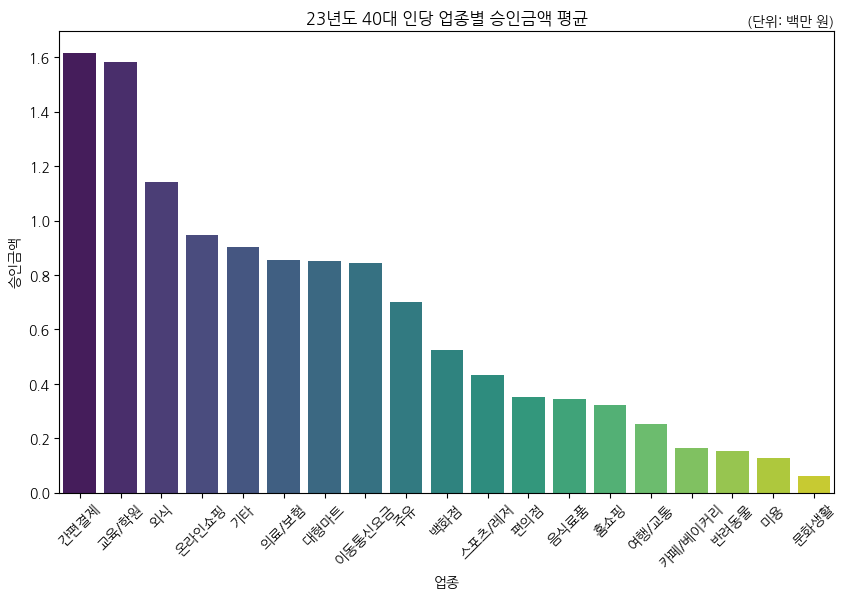

In [5]:
ID_업종별합산_40 = cc_23_40_r.groupby(['고객ID', '가맹점업종명'])['승인금액'].sum().reset_index()
# 가맹점업종명으로 그룹화하여 승인금액 평균 계산
업종별_승인금액_평균_40 = ID_업종별합산_40.groupby('가맹점업종명')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
업종별_승인금액_평균_40 = 업종별_승인금액_평균_40.sort_values(by='승인금액', ascending=False)


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# 그래프 설정
plt.rc('font', family='NanumGothic')
plt.figure(figsize=(10, 6))

업종별_승인금액_평균_40['승인금액_단위백'] = 업종별_승인금액_평균_40['승인금액'] / 1e6

sns.barplot(x='가맹점업종명', y='승인금액_단위백', data=업종별_승인금액_평균_40, palette="viridis")

# 제목 및 축 레이블 설정
plt.title('23년도 40대 인당 업종별 승인금액 평균')
plt.xlabel('업종')
plt.ylabel('승인금액')
plt.text(1, 1.02, "(단위: 백만 원)", ha='right', va='center', transform=plt.gca().transAxes, fontsize=10, color="black")

# x축 레이블 회전
plt.xticks(rotation=45)
#plt.savefig("22_40_인당업종별승인금액.png", format="png", dpi=300)
# 그래프 보여주기
plt.show()


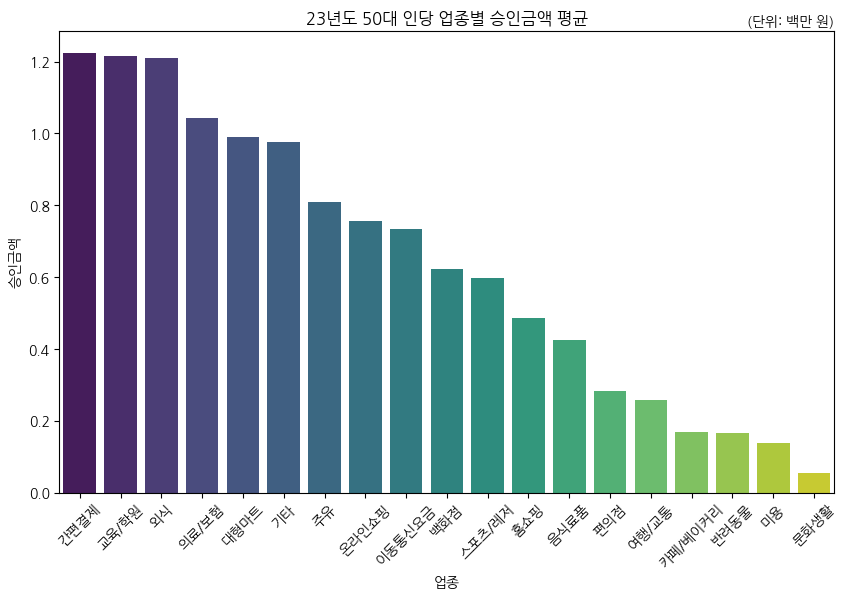

In [6]:
ID_업종별합산_40 = cc_23_50_r.groupby(['고객ID', '가맹점업종명'])['승인금액'].sum().reset_index()
# 가맹점업종명으로 그룹화하여 승인금액 평균 계산
업종별_승인금액_평균_40 = ID_업종별합산_40.groupby('가맹점업종명')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
업종별_승인금액_평균_40 = 업종별_승인금액_평균_40.sort_values(by='승인금액', ascending=False)


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# 그래프 설정
plt.rc('font', family='NanumGothic')
plt.figure(figsize=(10, 6))

업종별_승인금액_평균_40['승인금액_단위백'] = 업종별_승인금액_평균_40['승인금액'] / 1e6

sns.barplot(x='가맹점업종명', y='승인금액_단위백', data=업종별_승인금액_평균_40, palette="viridis")

# 제목 및 축 레이블 설정
plt.title('23년도 50대 인당 업종별 승인금액 평균')
plt.xlabel('업종')
plt.ylabel('승인금액')
plt.text(1, 1.02, "(단위: 백만 원)", ha='right', va='center', transform=plt.gca().transAxes, fontsize=10, color="black")

# x축 레이블 회전
plt.xticks(rotation=45)
#plt.savefig("22_50_인당업종별승인금액.png", format="png", dpi=300)
# 그래프 보여주기
plt.show()


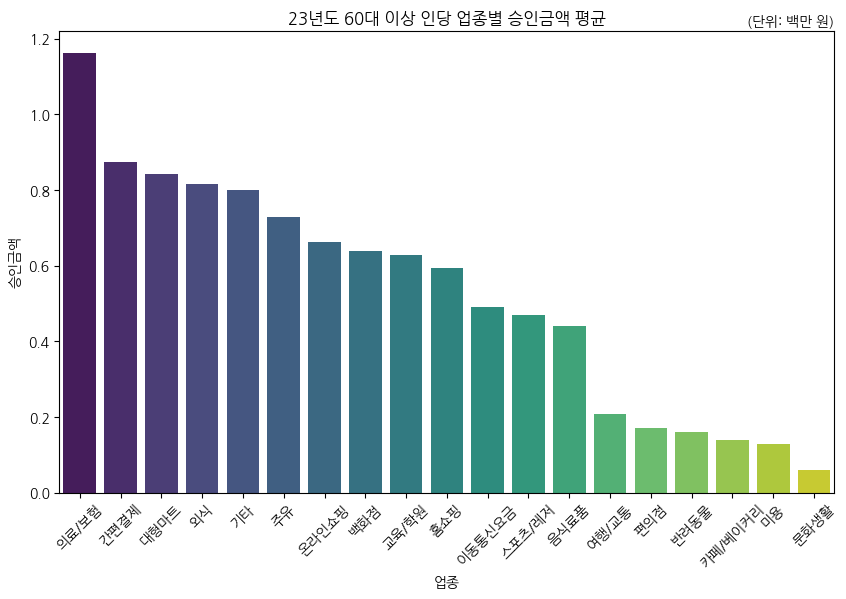

In [8]:
ID_업종별합산_40 = cc_23_60_r.groupby(['고객ID', '가맹점업종명'])['승인금액'].sum().reset_index()
# 가맹점업종명으로 그룹화하여 승인금액 평균 계산
업종별_승인금액_평균_40 = ID_업종별합산_40.groupby('가맹점업종명')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
업종별_승인금액_평균_40 = 업종별_승인금액_평균_40.sort_values(by='승인금액', ascending=False)


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# 그래프 설정
plt.rc('font', family='NanumGothic')
plt.figure(figsize=(10, 6))

업종별_승인금액_평균_40['승인금액_단위백'] = 업종별_승인금액_평균_40['승인금액'] / 1e6

sns.barplot(x='가맹점업종명', y='승인금액_단위백', data=업종별_승인금액_평균_40, palette="viridis")

# 제목 및 축 레이블 설정
plt.title('23년도 60대 이상 인당 업종별 승인금액 평균')
plt.xlabel('업종')
plt.ylabel('승인금액')
plt.text(1, 1.02, "(단위: 백만 원)", ha='right', va='center', transform=plt.gca().transAxes, fontsize=10, color="black")

# x축 레이블 회전
plt.xticks(rotation=45)
plt.savefig("22_60_인당업종별승인금액.png", format="png", dpi=300)
# 그래프 보여주기
plt.show()

# 업종별 합계

In [10]:
cc_23_40_r.head()

,고객ID,거래년월,가맹점업종명,가맹점_광역시도,가맹점_시군구,승인건수,승인금액,분류
0,9997288918,202312,기타,서울특별시,중구,5번이하,12680,기타
1,9997288918,202312,대형마트,경상북도,경산시,5번이하,30144,쇼핑
2,9997288918,202312,음식료품,경상남도,김해시,5번이하,26899,식음료
3,9997288918,202312,편의점,경상북도,김천시,5번이하,29338,쇼핑
4,9997288918,202312,외식,경상북도,김천시,5번이하,17482,식음료


In [11]:
cc_23_40_r['연령대'] = "40대"

In [13]:
cc_23_40_r.head()

,고객ID,거래년월,가맹점업종명,가맹점_광역시도,가맹점_시군구,승인건수,승인금액,분류,연령대
0,9997288918,202312,기타,서울특별시,중구,5번이하,12680,기타,40대
1,9997288918,202312,대형마트,경상북도,경산시,5번이하,30144,쇼핑,40대
2,9997288918,202312,음식료품,경상남도,김해시,5번이하,26899,식음료,40대
3,9997288918,202312,편의점,경상북도,김천시,5번이하,29338,쇼핑,40대
4,9997288918,202312,외식,경상북도,김천시,5번이하,17482,식음료,40대


In [14]:
cc_23_50_r['연령대'] = "50대"

In [15]:
cc_23_60_r['연령대'] = "60대 이상"

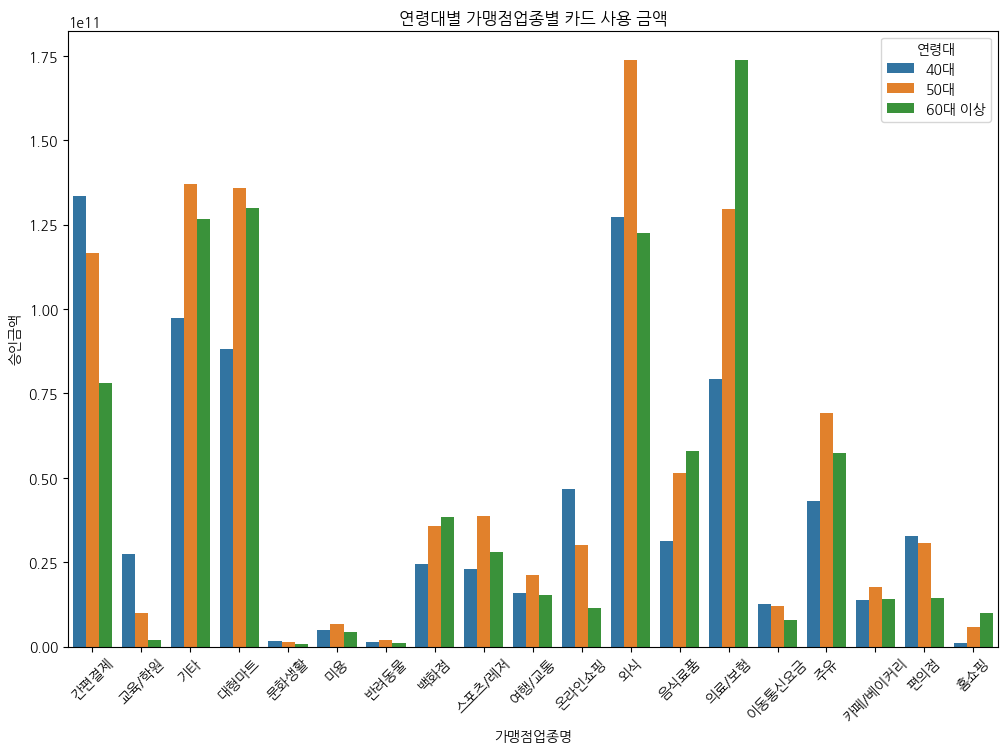

F-statistic: 0.25026462231296875, p-value: 0.7794927579634681
연령대 간의 승인금액 차이가 통계적으로 유의미하지 않습니다.


In [17]:
combined_data = pd.concat([cc_23_40_r[['가맹점업종명', '승인금액', '연령대']],
                            cc_23_50_r[['가맹점업종명', '승인금액', '연령대']],
                            cc_23_60_r[['가맹점업종명', '승인금액', '연령대']]])

# 가맹점업종별 승인금액 합계
age_group_summary = combined_data.groupby(['연령대', '가맹점업종명'])['승인금액'].sum().reset_index()

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=age_group_summary, x='가맹점업종명', y='승인금액', hue='연령대')
plt.title('연령대별 가맹점업종별 카드 사용 금액')
plt.xticks(rotation=45)
plt.legend(title='연령대')
plt.show()

# 총 승인금액 차이 분석을 위한 피벗 테이블 생성
pivot_table = age_group_summary.pivot(index='가맹점업종명', columns='연령대', values='승인금액').fillna(0)

# ANOVA 분석
f_statistic, p_value = stats.f_oneway(pivot_table['40대'], pivot_table['50대'], pivot_table['60대 이상'])

# 결과 출력
print(f'F-statistic: {f_statistic}, p-value: {p_value}')

# 결과 해석
if p_value < 0.05:
    print("연령대 간의 승인금액 차이가 통계적으로 유의미합니다.")
else:
    print("연령대 간의 승인금액 차이가 통계적으로 유의미하지 않습니다.")

In [5]:
ID_업종별합산_40 = cc_23_40_r.groupby(['고객ID', '가맹점업종명'])['승인금액'].sum().reset_index()
# 가맹점업종명으로 그룹화하여 승인금액 평균 계산
업종별_승인금액_평균_40 = ID_업종별합산_40.groupby('가맹점업종명')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
업종별_승인금액_평균_40 = 업종별_승인금액_평균_40.sort_values(by='승인금액', ascending=False)

ID_업종별합산_50 = cc_23_50_r.groupby(['고객ID', '가맹점업종명'])['승인금액'].sum().reset_index()
# 가맹점업종명으로 그룹화하여 승인금액 평균 계산
업종별_승인금액_평균_50 = ID_업종별합산_50.groupby('가맹점업종명')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
업종별_승인금액_평균_50 = 업종별_승인금액_평균_50.sort_values(by='승인금액', ascending=False)

ID_업종별합산_60 = cc_23_60_r.groupby(['고객ID', '가맹점업종명'])['승인금액'].sum().reset_index()
# 가맹점업종명으로 그룹화하여 승인금액 평균 계산
업종별_승인금액_평균_60 = ID_업종별합산_60.groupby('가맹점업종명')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
업종별_승인금액_평균_60 = 업종별_승인금액_평균_60.sort_values(by='승인금액', ascending=False)





In [6]:
업종별_승인금액_평균_60.head()

,가맹점업종명,승인금액
13,의료/보험,"1,163,249"
0,간편결제,"873,648"
3,대형마트,"843,370"
11,외식,"816,903"
2,기타,"801,069"


In [7]:
업종별_승인금액_평균_60['연령대'] = "60대 이상"

In [8]:
업종별_승인금액_평균_50['연령대'] = "50대"

In [9]:
업종별_승인금액_평균_40['연령대'] = "40대"

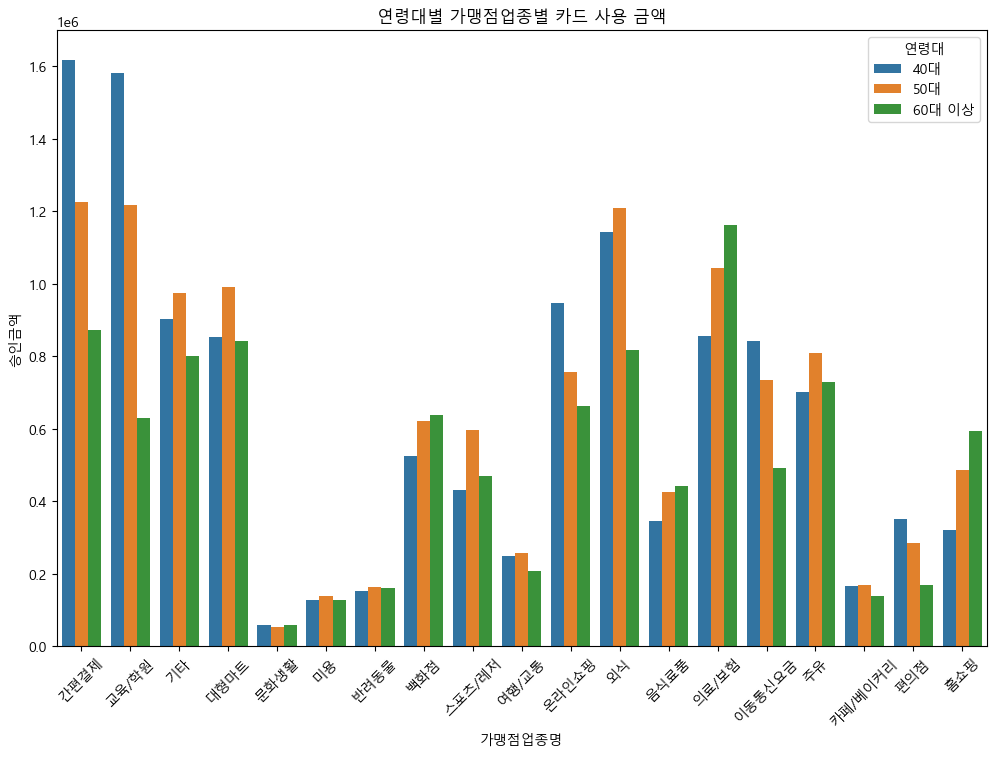

F-statistic: 0.5113901384567489, p-value: 0.6025362353441357
연령대 간의 승인금액 차이가 통계적으로 유의미하지 않습니다.


In [10]:
combined_data = pd.concat([업종별_승인금액_평균_40[['가맹점업종명', '승인금액', '연령대']],
                            업종별_승인금액_평균_50[['가맹점업종명', '승인금액', '연령대']],
                            업종별_승인금액_평균_60[['가맹점업종명', '승인금액', '연령대']]])

# 가맹점업종별 승인금액 합계
age_group_summary = combined_data.groupby(['연령대', '가맹점업종명'])['승인금액'].sum().reset_index()

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=age_group_summary, x='가맹점업종명', y='승인금액', hue='연령대')
plt.title('연령대별 가맹점업종별 카드 사용 금액')
plt.xticks(rotation=45)
plt.legend(title='연령대')
plt.show()

# 총 승인금액 차이 분석을 위한 피벗 테이블 생성
pivot_table = age_group_summary.pivot(index='가맹점업종명', columns='연령대', values='승인금액').fillna(0)

# ANOVA 분석
f_statistic, p_value = stats.f_oneway(pivot_table['40대'], pivot_table['50대'], pivot_table['60대 이상'])

# 결과 출력
print(f'F-statistic: {f_statistic}, p-value: {p_value}')

# 결과 해석
if p_value < 0.05:
    print("연령대 간의 승인금액 차이가 통계적으로 유의미합니다.")
else:
    print("연령대 간의 승인금액 차이가 통계적으로 유의미하지 않습니다.")



# 확인필요

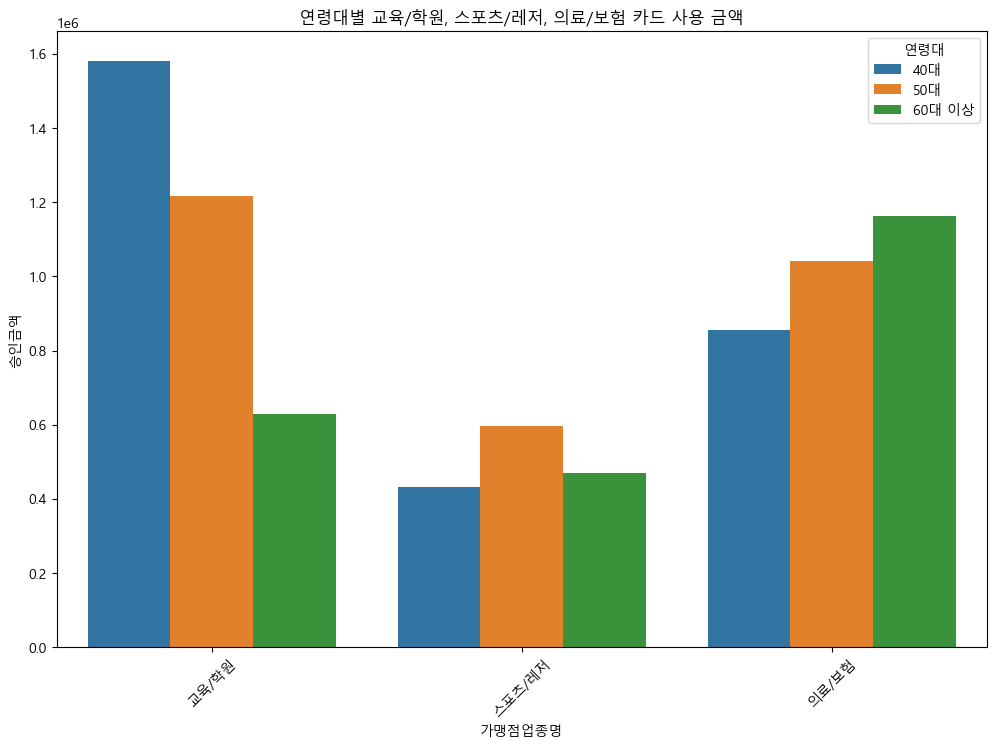

In [11]:
# 특정 카테고리 필터링
filtered_data = combined_data[combined_data['가맹점업종명'].isin(['교육/학원', '스포츠/레저', '의료/보험'])]

# 그룹화된 데이터 다시 생성
age_group_summary_filtered = filtered_data.groupby(['연령대', '가맹점업종명'])['승인금액'].sum().reset_index()

# 필터링된 데이터로 그래프 생성
plt.figure(figsize=(12, 8))
sns.barplot(data=age_group_summary_filtered, x='가맹점업종명', y='승인금액', hue='연령대')
plt.title('연령대별 교육/학원, 스포츠/레저, 의료/보험 카드 사용 금액')
plt.ylabel('승인금액')
plt.xticks(rotation=45)
plt.show()


In [12]:
age_group_summary_filtered

,연령대,가맹점업종명,승인금액
0,40대,교육/학원,"1,581,551"
1,40대,스포츠/레저,"431,911"
2,40대,의료/보험,"855,920"
3,50대,교육/학원,"1,215,941"
4,50대,스포츠/레저,"596,102"
5,50대,의료/보험,"1,042,543"
6,60대 이상,교육/학원,"628,642"
7,60대 이상,스포츠/레저,"470,764"
8,60대 이상,의료/보험,"1,163,249"


In [19]:
ID_분류별합산_40 = cc_23_40_r.groupby(['고객ID', '분류'])['승인금액'].sum().reset_index()
# 가맹점업종명으로 그룹화하여 승인금액 평균 계산
분류별_승인금액_평균_40 = ID_분류별합산_40.groupby('분류')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
분류별_승인금액_평균_40 = 분류별_승인금액_평균_40.sort_values(by='승인금액', ascending=False)

ID_분류별합산_50 = cc_23_50_r.groupby(['고객ID', '분류'])['승인금액'].sum().reset_index()
# 가맹점업종명으로 그룹화하여 승인금액 평균 계산
분류별_승인금액_평균_50 = ID_분류별합산_50.groupby('분류')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
분류별_승인금액_평균_50 = 분류별_승인금액_평균_50.sort_values(by='승인금액', ascending=False)

ID_분류별합산_60 = cc_23_60_r.groupby(['고객ID', '분류'])['승인금액'].sum().reset_index()
# 가맹점업종명으로 그룹화하여 승인금액 평균 계산
분류별_승인금액_평균_60 = ID_분류별합산_60.groupby('분류')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
분류별_승인금액_평균_60 = 분류별_승인금액_평균_60.sort_values(by='승인금액', ascending=False)


분류별_승인금액_평균_60['연령대'] = "60대 이상"
분류별_승인금액_평균_50['연령대'] = "50대"
분류별_승인금액_평균_40['연령대'] = "40대"

In [20]:
분류별_승인금액_평균_40

,분류,승인금액,연령대
2,쇼핑,"2,673,768",40대
1,생활비,"1,592,463",40대
3,식음료,"1,481,678",40대
0,기타,"902,960",40대
4,여가,"480,233",40대


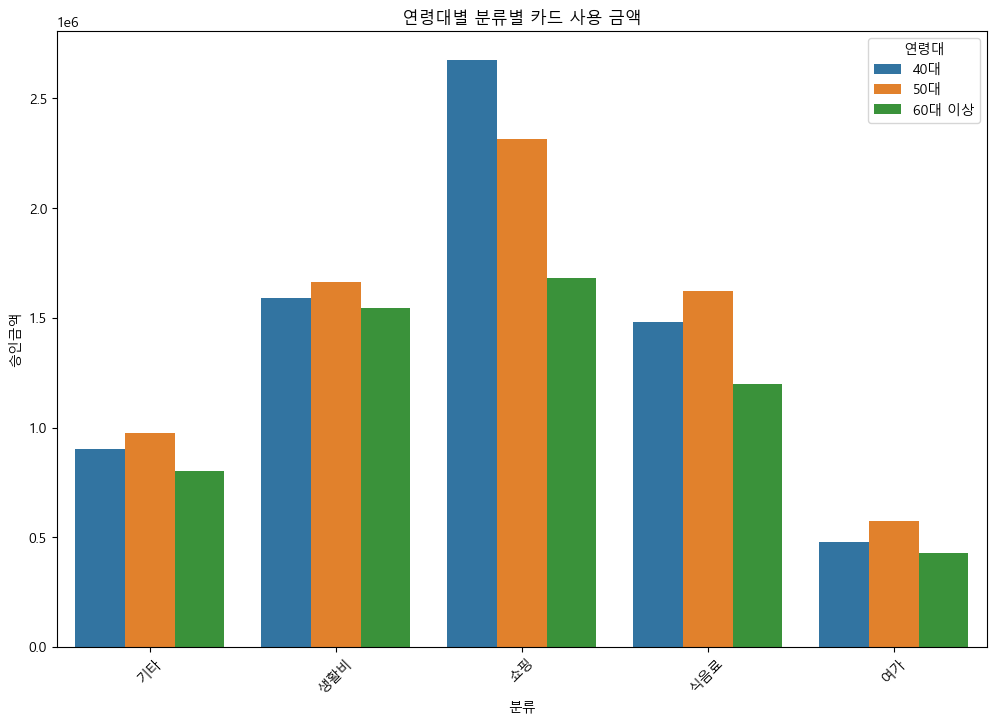

F-statistic: 0.3123967619691285, p-value: 0.7374656086452898
연령대 간의 승인금액 차이가 통계적으로 유의미하지 않습니다.


In [23]:

combined_data = pd.concat([분류별_승인금액_평균_40[['분류', '승인금액', '연령대']],
                            분류별_승인금액_평균_50[['분류', '승인금액', '연령대']],
                            분류별_승인금액_평균_60[['분류', '승인금액', '연령대']]])

# 가맹점업종별 승인금액 합계
age_group_summary = combined_data.groupby(['연령대', '분류'])['승인금액'].sum().reset_index()

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=age_group_summary, x='분류', y='승인금액', hue='연령대')
plt.title('연령대별 분류별 카드 사용 금액')
plt.xticks(rotation=45)
plt.legend(title='연령대')
plt.show()

# 총 승인금액 차이 분석을 위한 피벗 테이블 생성
pivot_table = age_group_summary.pivot(index='분류', columns='연령대', values='승인금액').fillna(0)

# ANOVA 분석
f_statistic, p_value = stats.f_oneway(pivot_table['40대'], pivot_table['50대'], pivot_table['60대 이상'])

# 결과 출력
print(f'F-statistic: {f_statistic}, p-value: {p_value}')

# 결과 해석
if p_value < 0.05:
    print("연령대 간의 승인금액 차이가 통계적으로 유의미합니다.")
else:
    print("연령대 간의 승인금액 차이가 통계적으로 유의미하지 않습니다.")



In [32]:
sampled_data_all.head()

,분류,가맹점업종명,승인금액,연령대,연도
0,기타,기타,1698036,40대,2021
1,기타,기타,101842,40대,2021
2,기타,기타,1645445,40대,2021
3,기타,기타,57937,40대,2021
4,기타,기타,112312,40대,2021


In [33]:
sampled_data_all['가맹점업종명'].value_counts()

가맹점업종명
기타         30001
여행/교통      13813
의료/보험      13384
스포츠/레저     11916
외식         11677
음식료품       10035
대형마트        9920
주유          8570
카페/베이커리     8288
편의점         6653
간편결제        6232
문화생활        4271
미용          4232
백화점         3998
온라인쇼핑       2355
이동통신요금      1708
교육/학원       1098
반려동물        1007
홈쇼핑          843
Name: count, dtype: int64

In [34]:
sampled_data_all['분류'].value_counts()

분류
기타     30001
쇼핑     30001
식음료    30000
여가     30000
생활비    29999
Name: count, dtype: int64

In [44]:
sampled = sampled_data_all.loc[:, ['연도','연령대', '가맹점업종명', '분류', '승인금액']]

In [87]:
# 연도가 2023인 데이터만 필터링
sampled_filtered = sampled_data_all[sampled_data_all['연도'].isin([2023])]

# 결과 확인
print(sampled_filtered)


        분류  가맹점업종명     승인금액  연령대    연도
100001  기타      기타  1020542  40대  2023
100002  기타      기타  2895043  40대  2023
100003  기타      기타   697423  40대  2023
100004  기타      기타  2163675  40대  2023
100005  기타      기타  1275812  40대  2023
...     ..     ...      ...  ...   ...
149996  여가   여행/교통   123434  60대  2023
149997  여가  스포츠/레저    11327  60대  2023
149998  여가  스포츠/레저   440077  60대  2023
149999  여가   여행/교통    10598  60대  2023
150000  여가    문화생활    69701  60대  2023

[50000 rows x 5 columns]


In [88]:
sampled_40 = sampled_filtered[sampled_filtered['연령대'].isin(["40대"])]
sampled_40

,분류,가맹점업종명,승인금액,연령대,연도
100001,기타,기타,1020542,40대,2023
100002,기타,기타,2895043,40대,2023
100003,기타,기타,697423,40대,2023
100004,기타,기타,2163675,40대,2023
100005,기타,기타,1275812,40대,2023
...,...,...,...,...,...
143109,여가,스포츠/레저,130273,40대,2023
143110,여가,문화생활,50599,40대,2023
143111,여가,여행/교통,112629,40대,2023
143112,여가,여행/교통,326237,40대,2023


In [89]:
sampled_50 = sampled_filtered[sampled_filtered['연령대'].isin(["50대"])]
sampled_60 = sampled_filtered[sampled_filtered['연령대'].isin(["60대"])]

In [93]:
분류별_승인금액_평균_40 = sampled_40.groupby('분류')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
분류별_승인금액_평균_40 = 분류별_승인금액_평균_40.sort_values(by='승인금액', ascending=False)


분류별_승인금액_평균_50 = sampled_50.groupby('분류')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
분류별_승인금액_평균_50 = 분류별_승인금액_평균_50.sort_values(by='승인금액', ascending=False)


분류별_승인금액_평균_60 = sampled_60.groupby('분류')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
분류별_승인금액_평균_60 = 분류별_승인금액_평균_60.sort_values(by='승인금액', ascending=False)

분류별_승인금액_평균_60['연령대'] = "60대 이상"
분류별_승인금액_평균_50['연령대'] = "50대"
분류별_승인금액_평균_40['연령대'] = "40대"


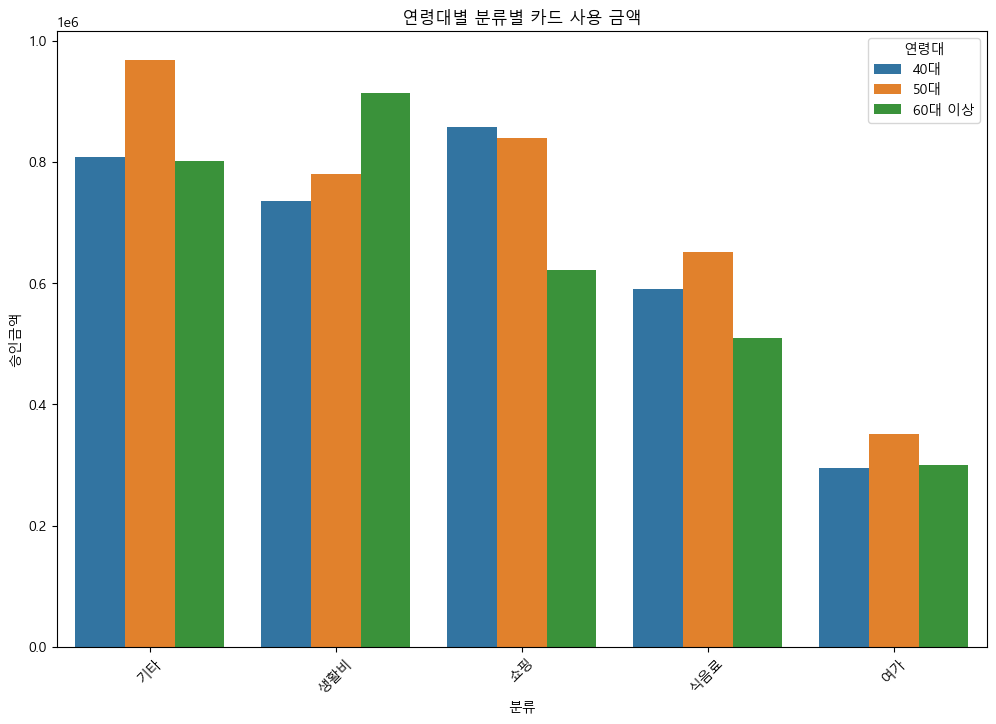

F-statistic: 0.18561826722211006, p-value: 0.8329305914238744
연령대 간의 승인금액 차이가 통계적으로 유의미하지 않습니다.


In [94]:

combined_data = pd.concat([분류별_승인금액_평균_40[['분류', '승인금액', '연령대']],
                            분류별_승인금액_평균_50[['분류', '승인금액', '연령대']],
                            분류별_승인금액_평균_60[['분류', '승인금액', '연령대']]])

# 가맹점업종별 승인금액 합계
age_group_summary = combined_data.groupby(['연령대', '분류'])['승인금액'].sum().reset_index()

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=age_group_summary, x='분류', y='승인금액', hue='연령대')
plt.title('연령대별 분류별 카드 사용 금액')
plt.xticks(rotation=45)
plt.legend(title='연령대')
plt.show()

# 총 승인금액 차이 분석을 위한 피벗 테이블 생성
pivot_table = age_group_summary.pivot(index='분류', columns='연령대', values='승인금액').fillna(0)

# ANOVA 분석
f_statistic, p_value = stats.f_oneway(pivot_table['40대'], pivot_table['50대'], pivot_table['60대 이상'])

# 결과 출력
print(f'F-statistic: {f_statistic}, p-value: {p_value}')

# 결과 해석
if p_value < 0.05:
    print("연령대 간의 승인금액 차이가 통계적으로 유의미합니다.")
else:
    print("연령대 간의 승인금액 차이가 통계적으로 유의미하지 않습니다.")



In [95]:
업종별_승인금액_평균_40 = sampled_40.groupby('가맹점업종명')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
업종별_승인금액_평균_40 = 업종별_승인금액_평균_40.sort_values(by='승인금액', ascending=False)


업종별_승인금액_평균_50 = sampled_50.groupby('가맹점업종명')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
업종별_승인금액_평균_50 = 업종별_승인금액_평균_50.sort_values(by='승인금액', ascending=False)


업종별_승인금액_평균_60 = sampled_60.groupby('가맹점업종명')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
업종별_승인금액_평균_60 = 업종별_승인금액_평균_60.sort_values(by='승인금액', ascending=False)

업종별_승인금액_평균_60['연령대'] = "60대 이상"
업종별_승인금액_평균_50['연령대'] = "50대"
업종별_승인금액_평균_40['연령대'] = "40대"


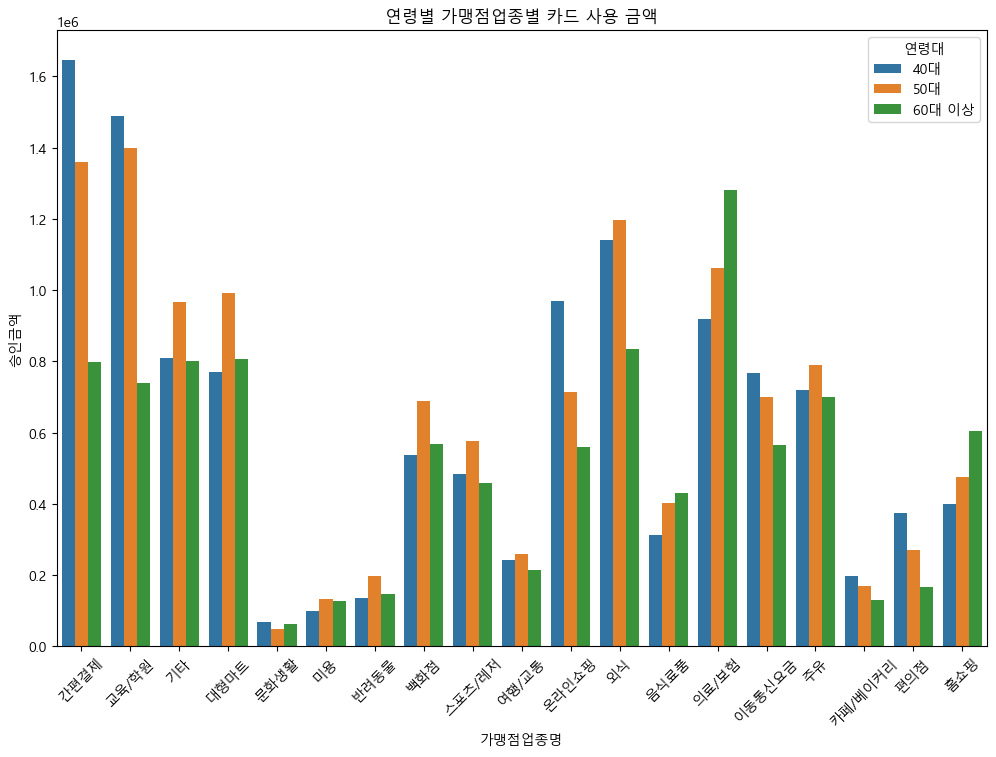

F-statistic: 0.5493457510898236, p-value: 0.5805195016929188
연령대 간의 승인금액 차이가 통계적으로 유의미하지 않습니다.


In [96]:

combined_data = pd.concat([업종별_승인금액_평균_40[['가맹점업종명', '승인금액', '연령대']],
                            업종별_승인금액_평균_50[['가맹점업종명', '승인금액', '연령대']],
                            업종별_승인금액_평균_60[['가맹점업종명', '승인금액', '연령대']]])

# 가맹점업종별 승인금액 합계
age_group_summary = combined_data.groupby(['연령대', '가맹점업종명'])['승인금액'].sum().reset_index()

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=age_group_summary, x='가맹점업종명', y='승인금액', hue='연령대')
plt.title('연령별 가맹점업종별 카드 사용 금액')
plt.xticks(rotation=45)
plt.legend(title='연령대')
plt.show()

# 총 승인금액 차이 분석을 위한 피벗 테이블 생성
pivot_table = age_group_summary.pivot(index='가맹점업종명', columns='연령대', values='승인금액').fillna(0)

# ANOVA 분석
f_statistic, p_value = stats.f_oneway(pivot_table['40대'], pivot_table['50대'], pivot_table['60대 이상'])

# 결과 출력
print(f'F-statistic: {f_statistic}, p-value: {p_value}')

# 결과 해석
if p_value < 0.05:
    print("연령대 간의 승인금액 차이가 통계적으로 유의미합니다.")
else:
    print("연령대 간의 승인금액 차이가 통계적으로 유의미하지 않습니다.")



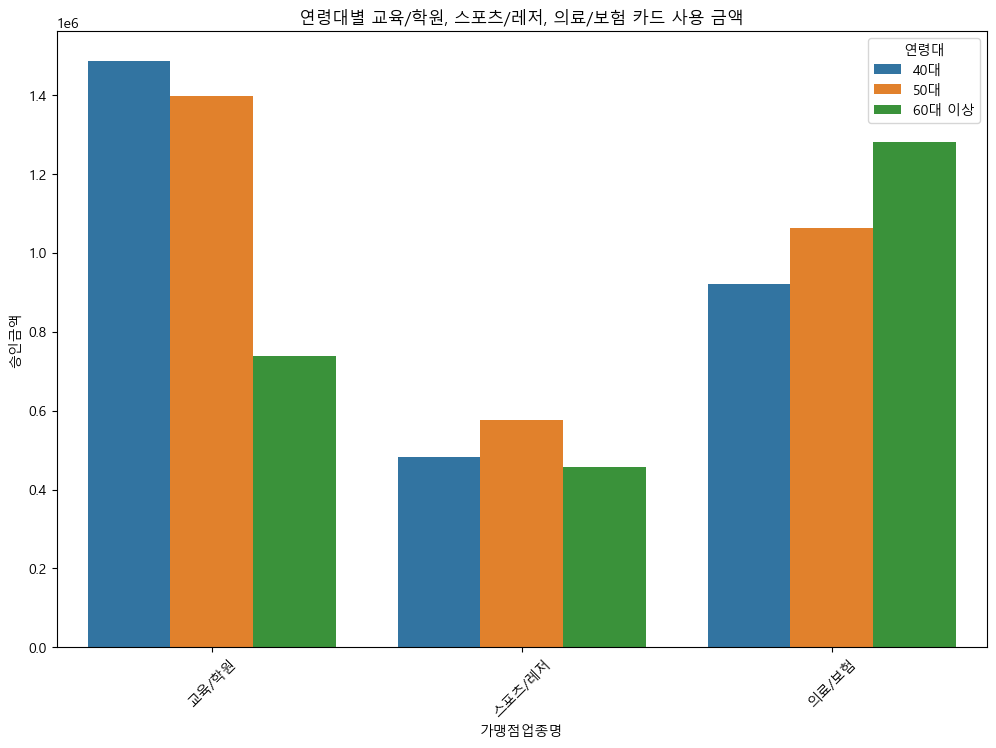

In [97]:
# 특정 카테고리 필터링
filtered_data = combined_data[combined_data['가맹점업종명'].isin(['교육/학원', '스포츠/레저', '의료/보험'])]

# 그룹화된 데이터 다시 생성
age_group_summary_filtered = filtered_data.groupby(['연령대', '가맹점업종명'])['승인금액'].sum().reset_index()

# 필터링된 데이터로 그래프 생성
plt.figure(figsize=(12, 8))
sns.barplot(data=age_group_summary_filtered, x='가맹점업종명', y='승인금액', hue='연령대')
plt.title('연령대별 교육/학원, 스포츠/레저, 의료/보험 카드 사용 금액')
plt.ylabel('승인금액')
plt.xticks(rotation=45)
plt.show()


In [100]:
age_group_summary_filtered # 23년

,연령대,가맹점업종명,승인금액
0,40대,교육/학원,"1,487,619"
1,40대,스포츠/레저,"482,857"
2,40대,의료/보험,"920,304"
3,50대,교육/학원,"1,398,970"
4,50대,스포츠/레저,"576,979"
5,50대,의료/보험,"1,062,173"
6,60대 이상,교육/학원,"739,308"
7,60대 이상,스포츠/레저,"457,624"
8,60대 이상,의료/보험,"1,282,272"


In [110]:
sampled_data_all.head()

,분류,가맹점업종명,승인금액,연령대,연도
0,기타,기타,1698036,40대,2021
1,기타,기타,101842,40대,2021
2,기타,기타,1645445,40대,2021
3,기타,기타,57937,40대,2021
4,기타,기타,112312,40대,2021


In [112]:
temp = sampled_data_all[sampled_data_all['분류'].isin(["여가"])]

In [113]:
temp

,분류,가맹점업종명,승인금액,연령대,연도
40001,여가,여행/교통,310166,40대,2021
40002,여가,여행/교통,44006,40대,2021
40003,여가,스포츠/레저,102925,40대,2021
40004,여가,여행/교통,32807,40대,2021
40005,여가,스포츠/레저,330073,40대,2021
...,...,...,...,...,...
149996,여가,여행/교통,123434,60대,2023
149997,여가,스포츠/레저,11327,60대,2023
149998,여가,스포츠/레저,440077,60대,2023
149999,여가,여행/교통,10598,60대,2023


In [115]:
temp = temp[temp['연도'].isin([2023])]
temp

,분류,가맹점업종명,승인금액,연령대,연도
140001,여가,문화생활,10739,40대,2023
140002,여가,스포츠/레저,185717,40대,2023
140003,여가,여행/교통,233649,40대,2023
140004,여가,스포츠/레저,8982,40대,2023
140005,여가,스포츠/레저,58087,40대,2023
...,...,...,...,...,...
149996,여가,여행/교통,123434,60대,2023
149997,여가,스포츠/레저,11327,60대,2023
149998,여가,스포츠/레저,440077,60대,2023
149999,여가,여행/교통,10598,60대,2023


In [116]:
temp['가맹점업종명'].value_counts()

가맹점업종명
여행/교통     4733
스포츠/레저    3850
문화생활      1417
Name: count, dtype: int64

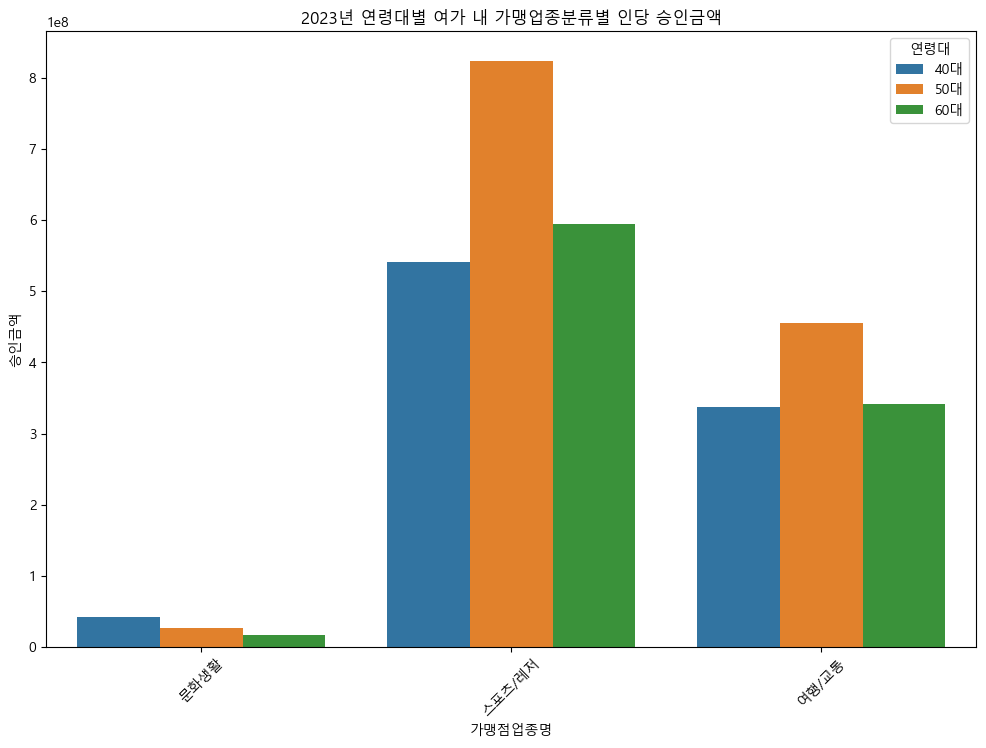

In [123]:

# 그룹화된 데이터 다시 생성
age_group_summary_temp = temp.groupby(['연령대', '가맹점업종명'])['승인금액'].sum().reset_index()

# 필터링된 데이터로 그래프 생성
plt.figure(figsize=(12, 8))
sns.barplot(data=age_group_summary_temp, x='가맹점업종명', y='승인금액', hue='연령대')
plt.title('2023년 연령대별 여가 내 가맹업종분류별 인당 승인금액')
plt.ylabel('승인금액')
plt.xticks(rotation=45)
plt.show()


In [7]:
sampled_data_all.head()

,분류,가맹점업종명,승인금액,연령대,연도
0,기타,기타,1698036,40대,2021
1,기타,기타,101842,40대,2021
2,기타,기타,1645445,40대,2021
3,기타,기타,57937,40대,2021
4,기타,기타,112312,40대,2021


# 확인 필요2

In [8]:
temp2 = sampled_data_all[sampled_data_all['분류'].isin(["생활비"])]
temp2 = temp2[temp2['연도'].isin([2023년])]

# 그룹화된 데이터 다시 생성
age_group_summary_temp2 = temp2.groupby(['연령대', '가맹점업종명'])['승인금액'].sum().reset_index()






# 필터링된 데이터로 그래프 생성
plt.figure(figsize=(12, 8))
sns.barplot(data=age_group_summary_temp2, x='가맹점업종명', y='승인금액', hue='연령대')
plt.title('2023년 연령대별 생활비 내 가맹업종분류별 인당 승인금액')
plt.ylabel('승인금액')
plt.xticks(rotation=45)
plt.show()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (384880140.py, line 2)

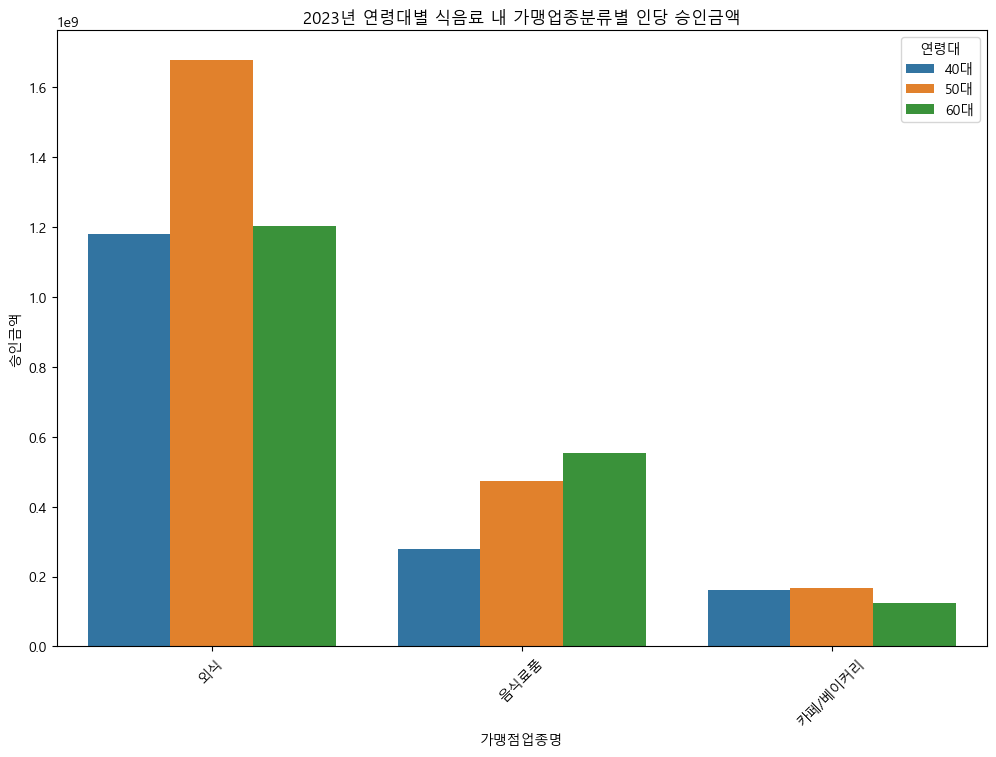

In [125]:
temp3 = sampled_data_all[sampled_data_all['분류'].isin(["식음료"])]
temp3 = temp3[temp3['연도'].isin([2023])]

# 그룹화된 데이터 다시 생성
age_group_summary_temp3 = temp3.groupby(['연령대', '가맹점업종명'])['승인금액'].sum().reset_index()

# 필터링된 데이터로 그래프 생성
plt.figure(figsize=(12, 8))
sns.barplot(data=age_group_summary_temp3, x='가맹점업종명', y='승인금액', hue='연령대')
plt.title('2023년 연령대별 식음료 내 가맹업종분류별 인당 승인금액')
plt.ylabel('승인금액')
plt.xticks(rotation=45)
plt.show()


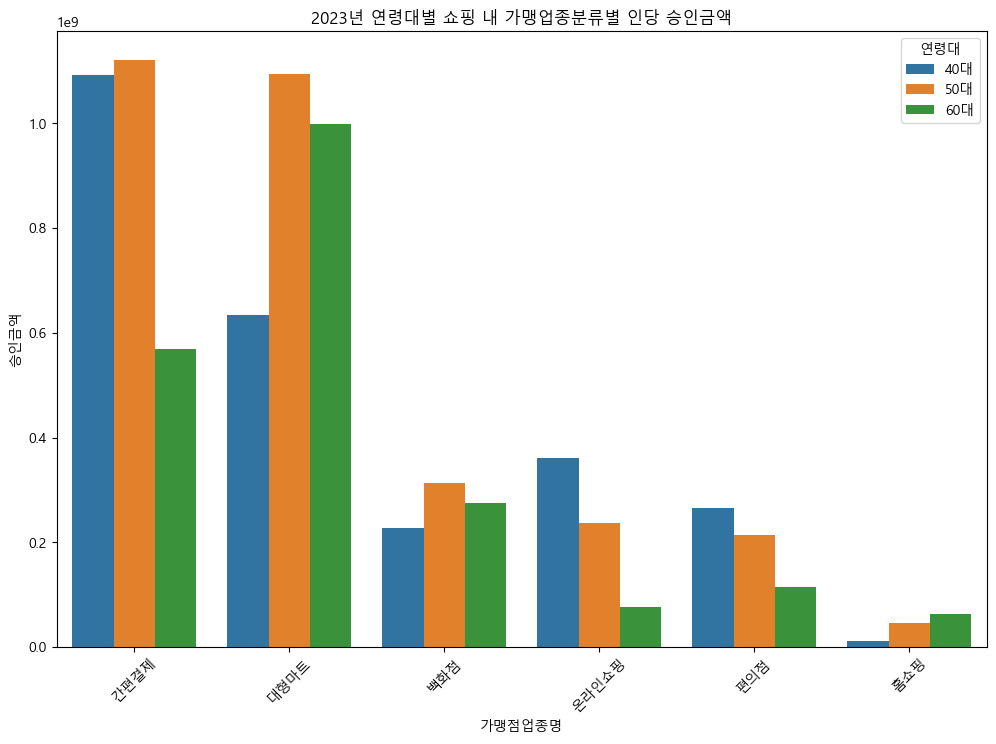

In [126]:
temp4 = sampled_data_all[sampled_data_all['분류'].isin(["쇼핑"])]
temp4 = temp4[temp4['연도'].isin([2023])]

# 그룹화된 데이터 다시 생성
age_group_summary_temp4 = temp4.groupby(['연령대', '가맹점업종명'])['승인금액'].sum().reset_index()

# 필터링된 데이터로 그래프 생성
plt.figure(figsize=(12, 8))
sns.barplot(data=age_group_summary_temp4, x='가맹점업종명', y='승인금액', hue='연령대')
plt.title('2023년 연령대별 쇼핑 내 가맹업종분류별 인당 승인금액')
plt.ylabel('승인금액')
plt.xticks(rotation=45)
plt.show()


In [101]:
# 연도가 2023인 데이터만 필터링
sampled_filtered_22 = sampled_data_all[sampled_data_all['연도'].isin([2022])]

sampled_40_22 = sampled_filtered_22[sampled_filtered_22['연령대'].isin(["40대"])]
sampled_50_22 = sampled_filtered_22[sampled_filtered_22['연령대'].isin(["50대"])]
sampled_60_22 = sampled_filtered_22[sampled_filtered_22['연령대'].isin(["60대"])]



In [102]:
분류별_승인금액_평균_40_22 = sampled_40_22.groupby('분류')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
분류별_승인금액_평균_40_22 = 분류별_승인금액_평균_40_22.sort_values(by='승인금액', ascending=False)


분류별_승인금액_평균_50_22 = sampled_50_22.groupby('분류')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
분류별_승인금액_평균_50_22 = 분류별_승인금액_평균_50_22.sort_values(by='승인금액', ascending=False)


분류별_승인금액_평균_60_22 = sampled_60_22.groupby('분류')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
분류별_승인금액_평균_60_22 = 분류별_승인금액_평균_60_22.sort_values(by='승인금액', ascending=False)

분류별_승인금액_평균_60_22['연령대'] = "60대 이상"
분류별_승인금액_평균_50_22['연령대'] = "50대"
분류별_승인금액_평균_40_22['연령대'] = "40대"


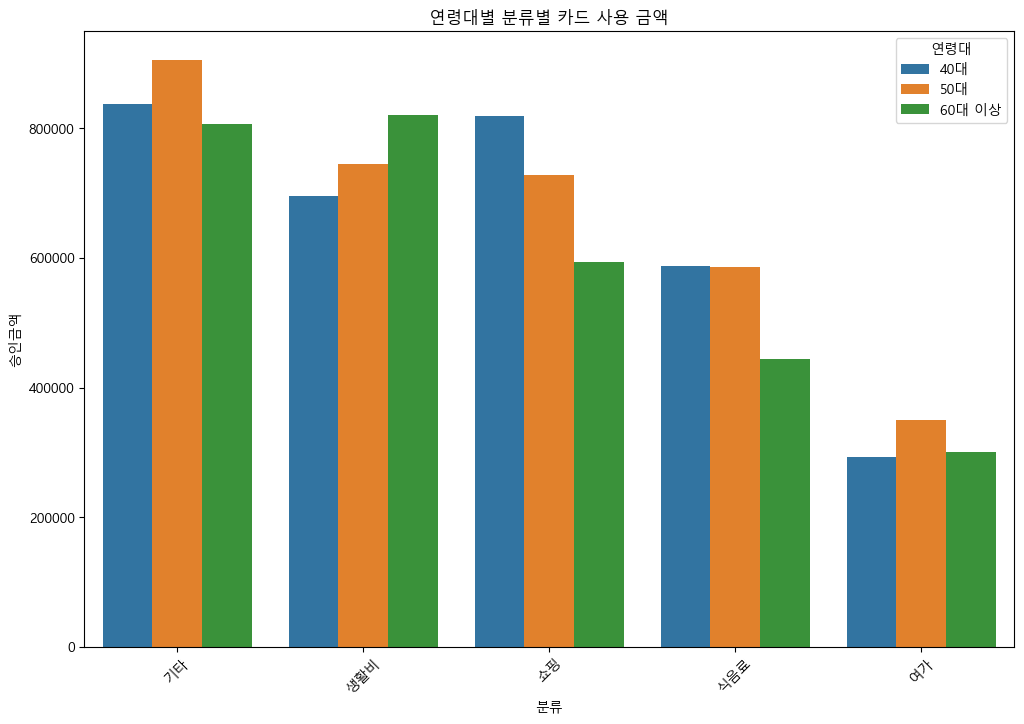

F-statistic: 0.1371843766496044, p-value: 0.8731572764551847
연령대 간의 승인금액 차이가 통계적으로 유의미하지 않습니다.


In [103]:

combined_data = pd.concat([분류별_승인금액_평균_40_22[['분류', '승인금액', '연령대']],
                            분류별_승인금액_평균_50_22[['분류', '승인금액', '연령대']],
                            분류별_승인금액_평균_60_22[['분류', '승인금액', '연령대']]])

# 가맹점업종별 승인금액 합계
age_group_summary = combined_data.groupby(['연령대', '분류'])['승인금액'].sum().reset_index()

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=age_group_summary, x='분류', y='승인금액', hue='연령대')
plt.title('연령대별 분류별 카드 사용 금액')
plt.xticks(rotation=45)
plt.legend(title='연령대')
plt.show()

# 총 승인금액 차이 분석을 위한 피벗 테이블 생성
pivot_table = age_group_summary.pivot(index='분류', columns='연령대', values='승인금액').fillna(0)

# ANOVA 분석
f_statistic, p_value = stats.f_oneway(pivot_table['40대'], pivot_table['50대'], pivot_table['60대 이상'])

# 결과 출력
print(f'F-statistic: {f_statistic}, p-value: {p_value}')

# 결과 해석
if p_value < 0.05:
    print("연령대 간의 승인금액 차이가 통계적으로 유의미합니다.")
else:
    print("연령대 간의 승인금액 차이가 통계적으로 유의미하지 않습니다.")



In [105]:
업종별_승인금액_평균_40_22 = sampled_40_22.groupby('가맹점업종명')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
업종별_승인금액_평균_40_22 = 업종별_승인금액_평균_40_22.sort_values(by='승인금액', ascending=False)


업종별_승인금액_평균_50_22 = sampled_50_22.groupby('가맹점업종명')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
업종별_승인금액_평균_50_22 = 업종별_승인금액_평균_50_22.sort_values(by='승인금액', ascending=False)


업종별_승인금액_평균_60_22 = sampled_60_22.groupby('가맹점업종명')['승인금액'].mean().reset_index()
# 과학적 표기법 해제
pd.options.display.float_format = '{:,.0f}'.format
# 승인금액을 기준으로 내림차순 정렬
업종별_승인금액_평균_60_22 = 업종별_승인금액_평균_60_22.sort_values(by='승인금액', ascending=False)

업종별_승인금액_평균_60_22['연령대'] = "60대 이상"
업종별_승인금액_평균_50_22['연령대'] = "50대"
업종별_승인금액_평균_40_22['연령대'] = "40대"


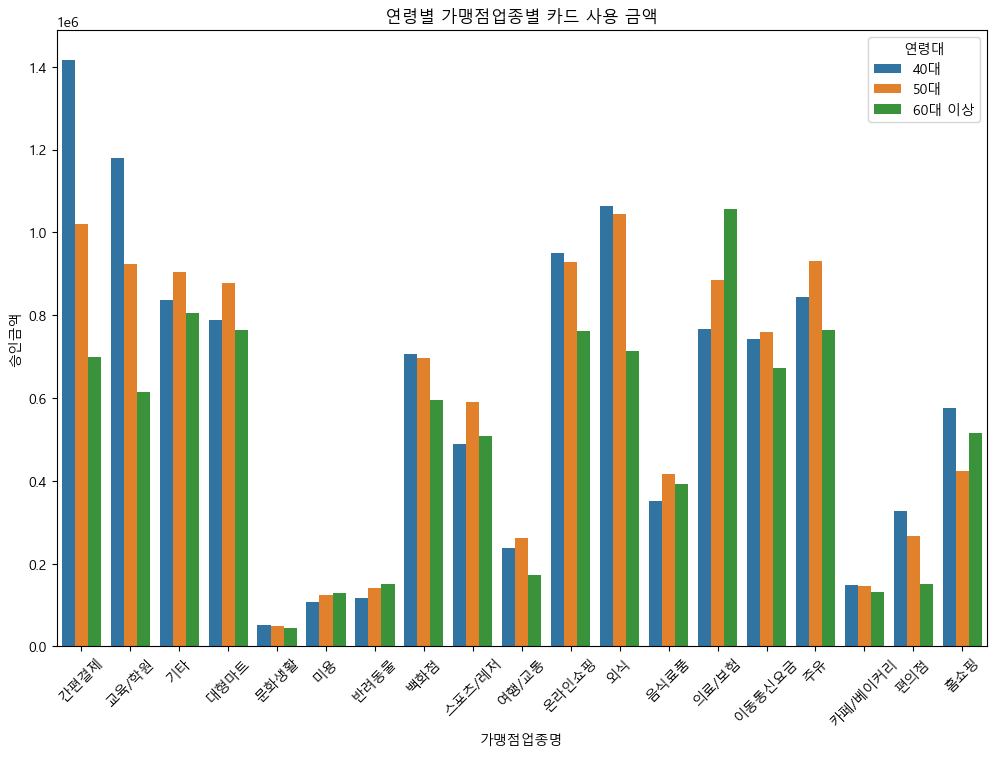

F-statistic: 0.5289184592909641, p-value: 0.5922629946457354
연령대 간의 승인금액 차이가 통계적으로 유의미하지 않습니다.


In [107]:

combined_data_22 = pd.concat([업종별_승인금액_평균_40_22[['가맹점업종명', '승인금액', '연령대']],
                            업종별_승인금액_평균_50_22[['가맹점업종명', '승인금액', '연령대']],
                            업종별_승인금액_평균_60_22[['가맹점업종명', '승인금액', '연령대']]])

# 가맹점업종별 승인금액 합계
age_group_summary_22 = combined_data_22.groupby(['연령대', '가맹점업종명'])['승인금액'].sum().reset_index()

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=age_group_summary, x='가맹점업종명', y='승인금액', hue='연령대')
plt.title('연령별 가맹점업종별 카드 사용 금액')
plt.xticks(rotation=45)
plt.legend(title='연령대')
plt.show()

# 총 승인금액 차이 분석을 위한 피벗 테이블 생성
pivot_table = age_group_summary.pivot(index='가맹점업종명', columns='연령대', values='승인금액').fillna(0)

# ANOVA 분석
f_statistic, p_value = stats.f_oneway(pivot_table['40대'], pivot_table['50대'], pivot_table['60대 이상'])

# 결과 출력
print(f'F-statistic: {f_statistic}, p-value: {p_value}')

# 결과 해석
if p_value < 0.05:
    print("연령대 간의 승인금액 차이가 통계적으로 유의미합니다.")
else:
    print("연령대 간의 승인금액 차이가 통계적으로 유의미하지 않습니다.")



In [109]:
age_group_summary_22 # 22년

,연령대,가맹점업종명,승인금액
0,40대,간편결제,"1,416,949"
1,40대,교육/학원,"1,180,026"
2,40대,기타,"837,114"
3,40대,대형마트,"789,095"
4,40대,문화생활,"52,485"
5,40대,미용,"108,021"
6,40대,반려동물,"117,981"
7,40대,백화점,"705,996"
8,40대,스포츠/레저,"489,357"
9,40대,여행/교통,"238,111"


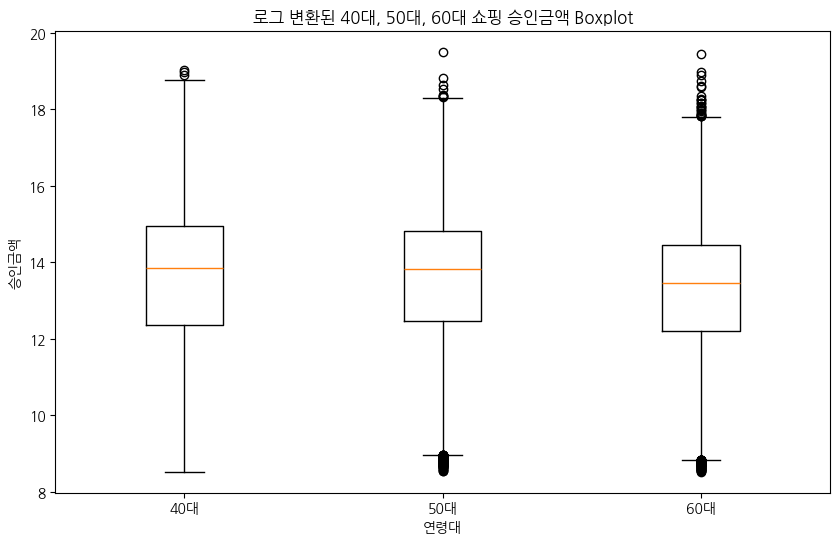

In [16]:
# 고객 ID와 분류별 승인금액 합계 구하기
cc_22_40_g = cc_22_40_r.groupby(['고객ID', '분류'])['승인금액'].sum().reset_index()
cc_22_50_g = cc_22_50_r.groupby(['고객ID', '분류'])['승인금액'].sum().reset_index()
cc_22_60_g = cc_22_60_r.groupby(['고객ID', '분류'])['승인금액'].sum().reset_index()

# '분류' 컬럼이 '쇼핑'인 데이터의 '승인금액'만 추출
cc_22_40_shop = np.log1p(cc_22_40_g[cc_22_40_g['분류'] == '쇼핑']['승인금액'])
cc_22_50_shop = np.log1p(cc_22_50_g[cc_22_50_g['분류'] == '쇼핑']['승인금액'])
cc_22_60_shop = np.log1p(cc_22_60_g[cc_22_60_g['분류'] == '쇼핑']['승인금액'])
# boxplot을 그리기 위해 데이터를 리스트로 정리
data = [cc_22_40_shop, cc_22_50_shop, cc_22_60_shop]
# 박스플롯 그리기
plt.rc('font', family='NanumGothic')
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=['40대', '50대', '60대'])
plt.title('로그 변환된 40대, 50대, 60대 쇼핑 승인금액 Boxplot')
plt.xlabel('연령대')
plt.ylabel('승인금액')
plt.show()

# 층화추출

In [29]:
# 고객 ID당 분류별 승인금액 합계 구하기
cc_23_40_sum = cc_23_40_r.groupby(['고객ID', '분류'])['승인금액'].sum().reset_index()
cc_23_50_sum = cc_23_50_r.groupby(['고객ID', '분류'])['승인금액'].sum().reset_index()
cc_23_60_sum = cc_23_60_r.groupby(['고객ID', '분류'])['승인금액'].sum().reset_index()
# 연령대 추가
cc_23_40_sum['연령대'] = '40대'
cc_23_50_sum['연령대'] = '50대'
cc_23_60_sum['연령대'] = '60대이상'
# 세 데이터를 하나로 결합
combined_data_23 = pd.concat([cc_23_40_sum, cc_23_50_sum, cc_23_60_sum])
combined_data_23 = combined_data_23.drop(columns=['고객ID'])
# 각 분류별 전체 건수와 연령대 비율 계산
total_counts = combined_data_23.groupby('분류').size()
age_counts = combined_data_23.groupby(['분류', '연령대']).size()
age_percentage = (age_counts / total_counts).unstack().fillna(0)
# 결과를 저장할 데이터프레임 초기화
sampled_data = pd.DataFrame()
# 각 분류별로 10,000개씩 샘플링
for category in age_percentage.index:
    category_data = combined_data_23[combined_data_23['분류'] == category]  # 해당 분류 데이터 필터링
    # 연령대별로 비율에 맞춰 샘플 개수 계산
    sample_counts = (age_percentage.loc[category] * 10000).round().astype(int)
    # 각 연령대에서 샘플 추출
    for age_group, count in sample_counts.items():
        age_data = category_data[category_data['연령대'] == age_group]
        # 데이터가 부족한 경우, 전체 데이터 사용
        sample_size = min(count, len(age_data))
        # 연령대별 샘플을 랜덤으로 추출하고 결합
        sampled_data = pd.concat([sampled_data, age_data.sample(sample_size, random_state=42)])
# 결과 확인
sampled_data.reset_index(drop=True, inplace=True)
sampled_data

,분류,승인금액,연령대
0,기타,384209,40대
1,기타,10266,40대
2,기타,11965,40대
3,기타,1218451,40대
4,기타,180338,40대
...,...,...,...
49995,여가,118772,60대이상
49996,여가,395830,60대이상
49997,여가,171223,60대이상
49998,여가,23274,60대이상
